# BMM via Gaussian Processes

## Author: Alexandra Semposki

### Date last edited: 06 June 2024

In this notebook, we produce the results in Section IV B of our paper on applying BMM to the equation of state (EOS) of asymmetric nuclear matter. Here, we attempt to use `scikit-learn` to develop a GP with correlated data input to perform BMM, using an altered version of the `GaussianProcessRegressor` class from `sklearn` that is able to incorporate this correlated data. We start with an RBF kernel and a Constant Kernel to optimize the marginal variance, $\bar{c}^{2}$. This kernel choice can be changed to reflect other priors the user may wish to implement. 

---

#### Table of contents

1. [Setting up the training data](#setup)
2. [Calculation of the mixed model in $P(n)$](#calc_p_n)
3. [Calculation of the speed of sound squared, $c_{s}^{2}(n)$](#calc_cs2)

---

In [33]:
# import needed packages
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from scripts import *

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Setting up the training data <a id="setup"></a>

First, we load in the data sets from $\chi$EFT and pQCD from which we will select training points, and choose the N3LO and N2LO results, respectively. Notice that we are using the results from pure $\chi$EFT, up to $2n_{0}$ only, since GPs do not need to have training points across the entire space to be used.

In [34]:
data_xeft_1 = np.load('../data/NSM_data/chiral_nsm_scaled.npz')
data_xeft_2 = np.load('quick_cheft_data.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled_NSM.npz')

Now we do some Python gymnastics to obtain the training points we'd like to use.

In [35]:
# call training function to obtain desired data (for both data sets)
cutoff = 40
training_data_1 = gp_data(data_xeft_1, data_pqcd, cutoff, all_orders=False, matter='SNM')

training_data_2 = gp_data(data_xeft_2, data_pqcd, cutoff, all_orders=False)

# save this to a file for later use in multi-plotter (uncomment to save)
# np.savez('../data/eos_data/correlated_training_data_40n0.npz', density=training_data['dens'], \
#          dens_log=np.log(training_data['dens']), mean=training_data['mean'], \
#          std=training_data['std'], cov=training_data['cov'])

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.4, 900)[:-1]

(9,) (9,) (9,) (9, 9)
(9,) (9,) (9,) (9, 9)
(4,) (4,) (4,) (4, 4)
Cov shape: (13, 13)
(7,) (7,) (7,) (7, 7)
(7,) (7,) (7,) (7, 7)
(4,) (4,) (4,) (4, 4)
Cov shape: (11, 11)


The cell below shows the results that we obtained for Table II in the paper (Sec. IV B). 

In [36]:
# print training data for Table II results
print('Density: \n', training_data_1['dens']/n0)
print('\nMean: \n', training_data_1['mean'])
print('\nStd dev: \n', training_data_1['std'])

# print training data for Table II results
print('\nDensity: \n', training_data_2['dens']/n0)
print('\nMean: \n', training_data_2['mean'])
print('\nStd dev: \n', training_data_2['std'])

Density: 
 [ 0.54399609  0.72112057  0.89824504  1.07536952  1.25249399  1.42961847
  1.60674295  1.78386742  1.9609919  40.08306527 56.72665825 73.37025123
 90.01384421]

Mean: 
 [0.04194479 0.05820944 0.08215813 0.11075182 0.14264947 0.17592907
 0.20850937 0.23830418 0.26323311 1.09534974 1.0861765  1.0805493
 1.07662893]

Std dev: 
 [0.00397468 0.00723183 0.01158179 0.01708058 0.0238976  0.03218158
 0.04213987 0.05405145 0.06828981 0.0192124  0.01519569 0.0129697
 0.01152593]

Density: 
 [ 0.77873692  0.99250784  1.20627876  1.42004968  1.6338206   1.84759151
  2.06136243 40.08306527 56.72665825 73.37025123 90.01384421]

Mean: 
 [0.06524622 0.09687112 0.13410977 0.17413035 0.21329646 0.24794129
 0.27441948 1.09534974 1.0861765  1.0805493  1.07662893]

Std dev: 
 [0.00827308 0.01385217 0.02112484 0.03033294 0.04180198 0.05599412
 0.07356306 0.0192124  0.01519569 0.0129697  0.01152593]


Now we get ready to plot the selected training data and the total means and uncertainties from the two theories. $\chi$EFT and pQCD are always displayed in red and blue, respectively.

In [37]:
errorbar_kwargs_1 = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)
errorbar_kwargs_2 = dict(
    capsize=3,
    ecolor="r",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

In [38]:
# chiral EFT data 
n_xeft_1 = data_xeft_1['density']
p_mean_xeft_1 = data_xeft_1['mean']#[:, -1]
p_stdv_xeft_1 = data_xeft_1['std_dev']#[:, -1]
p_cov_xeft_1 = data_xeft_1['cov']#[..., -1]

# chiral EFT data 
n_xeft_2 = data_xeft_2['density']
p_mean_xeft_2 = data_xeft_2['mean']#[:, -1]
p_stdv_xeft_2 = data_xeft_2['std_dev']#[:, -1]
p_cov_xeft_2 = data_xeft_2['cov']#[..., -1]

# get the pqcd curve to only plot greater than the cutoff choice
ind_cut = np.where(data_pqcd['density']/n0 >= cutoff)[0][0]

# pQCD data
n_pqcd = data_pqcd['density'][ind_cut:]
p_mean_pqcd = data_pqcd['mean'][ind_cut:, -1]
p_stdv_pqcd = data_pqcd['std_dev'][ind_cut:, -1]
p_cov_pqcd = data_pqcd['cov'][ind_cut:, ind_cut:, -1]

# save this for plotting later (uncomment to save)
#np.savez('../data/eos_data/pressure_pqcd_cut_40.npz', dens=n_pqcd, mean=p_mean_pqcd, std=p_stdv_pqcd)

Now we'll plot the current data sets with the cutoffs implemented for each, and the training points that we will be using to train the GP.

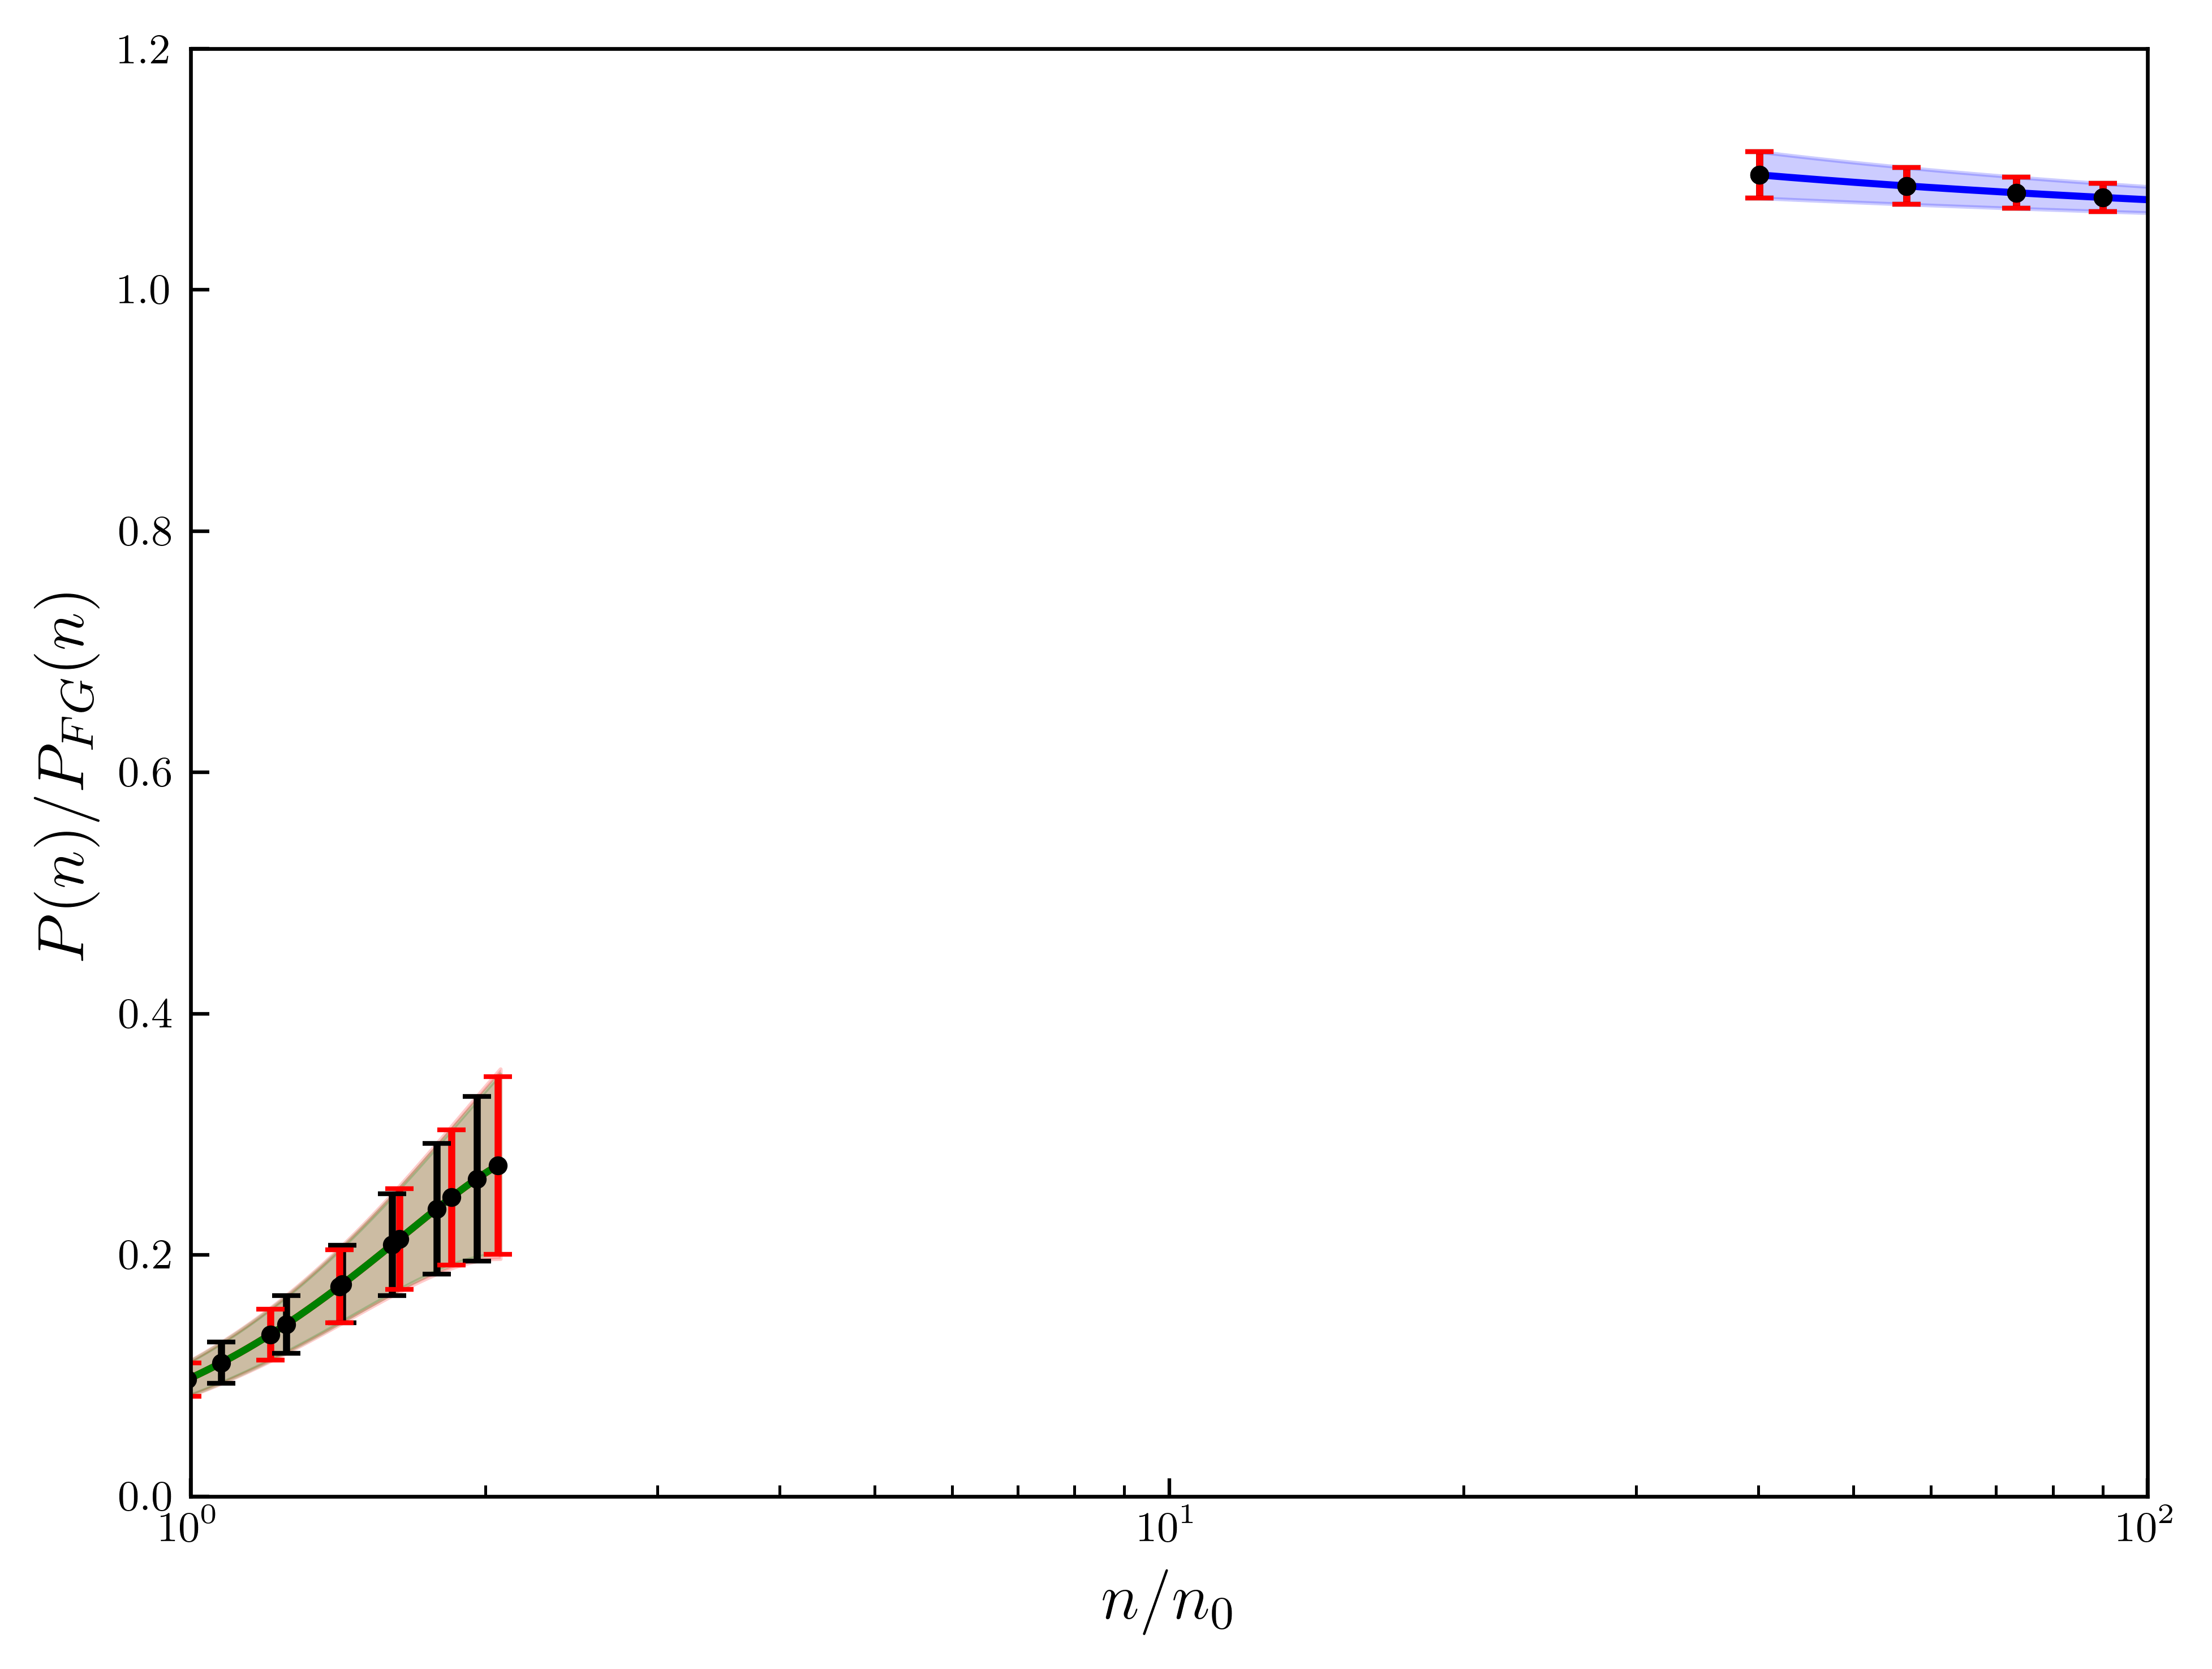

In [39]:
# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft_1 = "red"
color_xeft_2 = 'green'
color_pqcd = "blue"
ax.set_xlim(1.0, 100.0)
ax.set_ylim(0, 1.2)
ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)

# result of idea 1
ax.plot(n_xeft_1/n0, p_mean_xeft_1, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft_1/n0, p_mean_xeft_1-p_stdv_xeft_1, p_mean_xeft_1+p_stdv_xeft_1, \
                alpha=0.2, color=color_xeft_1)
ax.errorbar(x=training_data_1['dens']/n0, y=training_data_1['mean'], yerr=training_data_1['std'], \
            **errorbar_kwargs_1)

# result of idea 2
ax.plot(n_xeft_2/n0, p_mean_xeft_2, color='green', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft_2/n0, p_mean_xeft_2-p_stdv_xeft_2, p_mean_xeft_2+p_stdv_xeft_2, \
                alpha=0.2, color=color_xeft_2)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
#plt.legend()
plt.show()

## Calculation of $P(n)$ using a GP <a id="calc_p_n"></a>

Now we construct the kernel we wish to use, the RBF * constant kernel. Then we will feed this to the `GaussianProcessRegressor2dNoise` function that ties to `sklearn`, and fit to the training data we selected.

We also need to compare the results of the work with the comparison of what happens when I use the same covariance matrix, and fix the lengthscale to reflect the two kernels I see when I work on the RBF kernel with two different covariance matrices.

### Idea 1 training 

In [40]:
# set up the kernel
kernel_1 = C(constant_value=0.6) * RBF(length_scale=2.0) #Matern(length_scale=1.5, nu=1.5)

X_train_1 = np.log(training_data_1['dens']).reshape(-1,1)  # training in the log scale
y_train_1 = training_data_1['mean'].reshape(-1,1)

# set up the class for the GP
gp_1 = GaussianProcessRegressor2dNoise(
    kernel=kernel_1,
    alpha=training_data_1['cov']  # here is where we input the full covariance matrix from the data
)

gp_1.fit(X_train_1, y_train_1)  # fit to the data we selected from chiral EFT & pQCD

GaussianProcessRegressor2dNoise(alpha=array([[1.57980846e-05, 2.82482508e-05, 4.33622527e-05, 6.02582525e-05,
        7.84563055e-05, 9.74156384e-05, 1.16823374e-04, 1.36571975e-04,
        1.56744432e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.82482508e-05, 5.22993503e-05, 8.26989872e-05, 1.18029226e-04,
        1.57445530e-04, 1.99869940e-04, 2.44593515e-04, 2....
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.47809527e-04, 1.96830983e-04, 1.68213107e-04,
        1.49306828e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.18842202e-04, 1.74275189e-04, 1.49306828e-04,
        1.32847049e-04]]),
                                kernel=0.775**2 * RBF(length_scale=2))

We can print out the kernel hyperparameters ($\bar{c}$ and $\ell$) below, and see what we get using this kernel.

In [41]:
print(gp_1.kernel_)

0.564**2 * RBF(length_scale=1.1)


### Idea 2 training

In [42]:
# set up the kernel
kernel_2 = C(constant_value=0.6) * RBF(length_scale=2.5) #Matern(length_scale=1.5, nu=1.5)

X_train_2 = np.log(training_data_2['dens']).reshape(-1,1)  # training in the log scale
y_train_2 = training_data_2['mean'].reshape(-1,1)

# set up the class for the GP
gp_2 = GaussianProcessRegressor2dNoise(
    kernel=kernel_2,
    alpha=training_data_2['cov']  # here is where we input the full covariance matrix from the data
)

gp_2.fit(X_train_2, y_train_2)  # fit to the data we selected from chiral EFT & pQCD

/Users/alexandra/anaconda3/envs/BUQEYE/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor2dNoise(alpha=array([[7.70819246e-05, 1.29496329e-04, 1.93308450e-04, 2.66508238e-04,
        3.46994003e-04, 4.32700513e-04, 5.21676549e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.29496329e-04, 2.24299344e-04, 3.43883127e-04, 4.85629655e-04,
        6.46435016e-04, 8.22976242e-04, 1.01189132e-03, 0.00000000e+00,
        0.00000000e+00, 0....
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.47809527e-04,
        1.96830983e-04, 1.68213107e-04, 1.49306828e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.18842202e-04,
        1.74275189e-04, 1.49306828e-04, 1.32847049e-04]]),
                                kernel=0.775**2 * RBF(length_scale=2.5))

In [43]:
print(gp_2.kernel_)

0.669**2 * RBF(length_scale=1.79)


We then use the same kernel to predict at new points in density, and plot our GP result.

In [44]:
# conversion for speed of sound
# convert_pqcd = np.load('../data/eos_data/pqcd_fg_data.npz')

# # interpolate for a functional form to use 
# convert_interp = sp.interpolate.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
#                                  kind='cubic', fill_value='extrapolate')
# pqcd_convert_arr = convert_interp(density_test)

In [45]:
# use the testing density array now for predicting at new locations (also in log space)
X = np.log(density_test).reshape(-1,1)
y_pred_1, y_stdv_1 = gp_1.predict(X, return_std=True)
y_pred_2, y_stdv_2 = gp_2.predict(X, return_std=True)

# save for plotting later (uncomment to save)
#np.savez('../data/eos_data/gp_pressure_40.npz', dens=density_test, mean=y_pred, std=y_stdv)

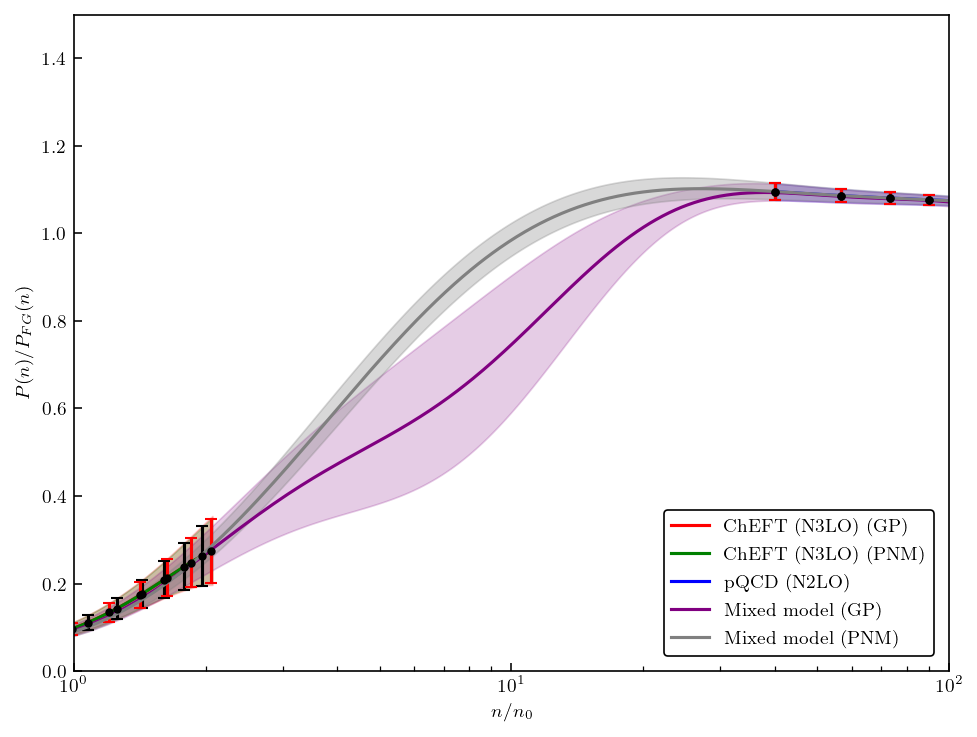

In [46]:
fig, ax = plt.subplots(dpi=150)
ax.set_xlim(1.0, 100.0)
ax.set_ylim(0, 1.5)
ax.set_xscale('log') # plot in log base 10
ax.set_xlabel(r'$n/n_{0}$')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$')

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft_1/n0, p_mean_xeft_1, color='red', label=r'ChEFT (N3LO) (GP)')
ax.fill_between(n_xeft_1/n0, p_mean_xeft_1-p_stdv_xeft_1, p_mean_xeft_1+p_stdv_xeft_1, alpha=0.2, \
                color=color_xeft_1)
ax.errorbar(x=training_data_1['dens']/n0, y=training_data_1['mean'], yerr=training_data_1['std'], \
            **errorbar_kwargs_1)

ax.plot(n_xeft_2/n0, p_mean_xeft_2, color='green', label=r'ChEFT (N3LO) (PNM)')
ax.fill_between(n_xeft_2/n0, p_mean_xeft_2-p_stdv_xeft_2, p_mean_xeft_2+p_stdv_xeft_2, alpha=0.2, \
                color=color_xeft_2)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)

ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)

# GP result and uncertainty band
ax.plot(density_test/n0, y_pred_1, c='purple', label=r'Mixed model (GP)')
ax.fill_between(density_test/n0, y_pred_1-y_stdv_1, y_pred_1+y_stdv_1, color="purple", alpha=0.2)

ax.plot(density_test/n0, y_pred_2, c='grey', label=r'Mixed model (PNM)')
ax.fill_between(density_test/n0, y_pred_2-y_stdv_2, y_pred_2+y_stdv_2, color="grey", alpha=0.3)

# import contours and plot
#df = pd.read_csv('../data/contour_scaled.csv')
#df_frg = pd.read_csv('../data/frg_data_pressure.csv')

# unscale FRG
#ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')
#ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', label='FRG contour')

plt.legend(loc='lower right')
#fig.savefig('../figures/RBF_comparison_cov.png')
plt.show()

In [47]:
# difference between std_dev of mixed result with the GP vs mixed result with PNM covariance
#print(y_stdv_1 - y_stdv_2)  # not very different
print((y_pred_1 +y_stdv_1) - (y_pred_2 + y_stdv_2))   # not very different 

[ 0.13528102  0.03794182  0.00984274  0.00265275  0.00181814  0.00284491
  0.00446075  0.00631749  0.00828317  0.01025161  0.01210838  0.01373798
  0.01503648  0.01592035  0.01633032  0.01623131  0.01561008  0.01447177
  0.01283603  0.01073333  0.0082017   0.00528393  0.00202531 -0.00152813
 -0.00533094 -0.00933929 -0.01351159 -0.01780901 -0.02219566 -0.0266388
 -0.03110876 -0.035579   -0.04002586 -0.04442852 -0.04876876 -0.05303081
 -0.05720113 -0.06126824 -0.06522252 -0.06905605 -0.07276242 -0.07633659
 -0.07977474 -0.08307412 -0.08623296 -0.0892503  -0.09212595 -0.09486036
 -0.09745453 -0.09990994 -0.10222852 -0.10441251 -0.10646447 -0.10838721
 -0.11018375 -0.11185726 -0.11341105 -0.11484853 -0.11617318 -0.11738855
 -0.11849818 -0.11950565 -0.12041454 -0.12122838 -0.12195071 -0.12258498
 -0.12313464 -0.12360305 -0.12399352 -0.12430929 -0.12455353 -0.12472932
 -0.12483968 -0.12488754 -0.12487576 -0.12480709 -0.12468422 -0.12450976
 -0.12428623 -0.12401606 -0.12370161 -0.12334514 -0.

__Conclusions so far__: PNM covariance matrix used definitely makes the overall result (using the same kernel and around the same training points) a bit fatter in the region directly above the Chiral EFT result, which will end up being the sensitive region in terms of M-R curves.

0.621**2 * RBF(length_scale=1.93)
0.618**2 * RBF(length_scale=2)


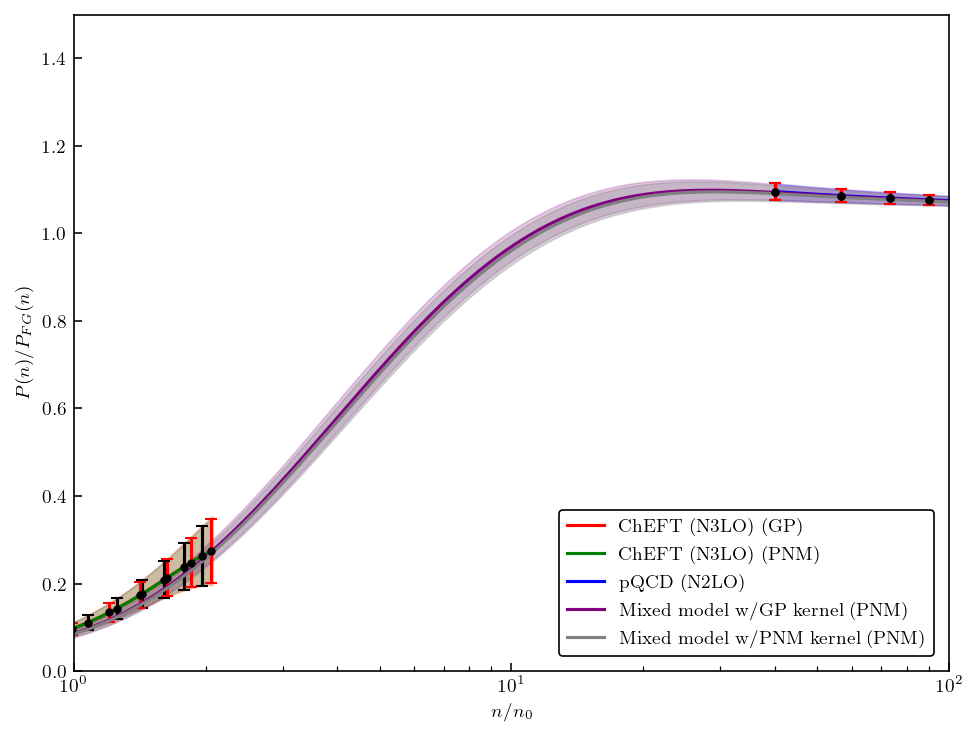

In [31]:
# design the same problem but with equal covariance matrices and fixed lengthscales
kernel_fix_1 = C(constant_value=0.621**2.0, constant_value_bounds='fixed') * \
RBF(length_scale=1.93, length_scale_bounds='fixed')

kernel_fix_2 = C(constant_value=0.618**2.0, constant_value_bounds='fixed') * \
RBF(length_scale=2.0, length_scale_bounds='fixed')

# fit both to the PNM covariance training data and see what happens
gp_fix_1 = GaussianProcessRegressor2dNoise(
    kernel=kernel_fix_1,
    alpha=training_data_2['cov']  # here is where we input the full covariance matrix from the data
)

gp_fix_1.fit(X_train_2, y_train_2)  # fit to the data we selected from chiral EFT & pQCD

gp_fix_2 = GaussianProcessRegressor2dNoise(
    kernel=kernel_fix_2,
    alpha=training_data_2['cov']  # here is where we input the full covariance matrix from the data
)

gp_fix_2.fit(X_train_2, y_train_2)  # fit to the data we selected from chiral EFT & pQCD

print(gp_fix_1.kernel_)
print(gp_fix_2.kernel_)

# predict now
y_pred_fix_1, y_stdv_fix_1 = gp_fix_1.predict(X, return_std=True)
y_pred_fix_2, y_stdv_fix_2 = gp_fix_2.predict(X, return_std=True)

# plot
fig, ax = plt.subplots(dpi=150)
ax.set_xlim(1.0, 100.0)
ax.set_ylim(0, 1.5)
ax.set_xscale('log') # plot in log base 10
ax.set_xlabel(r'$n/n_{0}$')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$')

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft_1/n0, p_mean_xeft_1, color='red', label=r'ChEFT (N3LO) (GP)')
ax.fill_between(n_xeft_1/n0, p_mean_xeft_1-p_stdv_xeft_1, p_mean_xeft_1+p_stdv_xeft_1, alpha=0.2, \
                color=color_xeft_1)
ax.errorbar(x=training_data_1['dens']/n0, y=training_data_1['mean'], yerr=training_data_1['std'], \
            **errorbar_kwargs_1)

ax.plot(n_xeft_2/n0, p_mean_xeft_2, color='green', label=r'ChEFT (N3LO) (PNM)')
ax.fill_between(n_xeft_2/n0, p_mean_xeft_2-p_stdv_xeft_2, p_mean_xeft_2+p_stdv_xeft_2, alpha=0.2, \
                color=color_xeft_2)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)

ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)

# GP result and uncertainty band
ax.plot(density_test/n0, y_pred_fix_1, c='purple', label=r'Mixed model w/GP kernel (PNM)')
ax.fill_between(density_test/n0, y_pred_fix_1-y_stdv_fix_1, y_pred_fix_1+y_stdv_fix_1, \
                color="purple", alpha=0.2)

ax.plot(density_test/n0, y_pred_fix_2, c='grey', label=r'Mixed model w/PNM kernel (PNM)')
ax.fill_between(density_test/n0, y_pred_fix_2-y_stdv_fix_2, y_pred_fix_2+y_stdv_fix_2, color="grey", alpha=0.3)

# import contours and plot
#df = pd.read_csv('../data/contour_scaled.csv')
#df_frg = pd.read_csv('../data/frg_data_pressure.csv')

# unscale FRG
#ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')
#ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', label='FRG contour')

plt.legend(loc='lower right')
fig.savefig('../figures/RBF_comparison_fixed_cov.png')
plt.show()

0.67**2 * RBF(length_scale=5.33e-05)


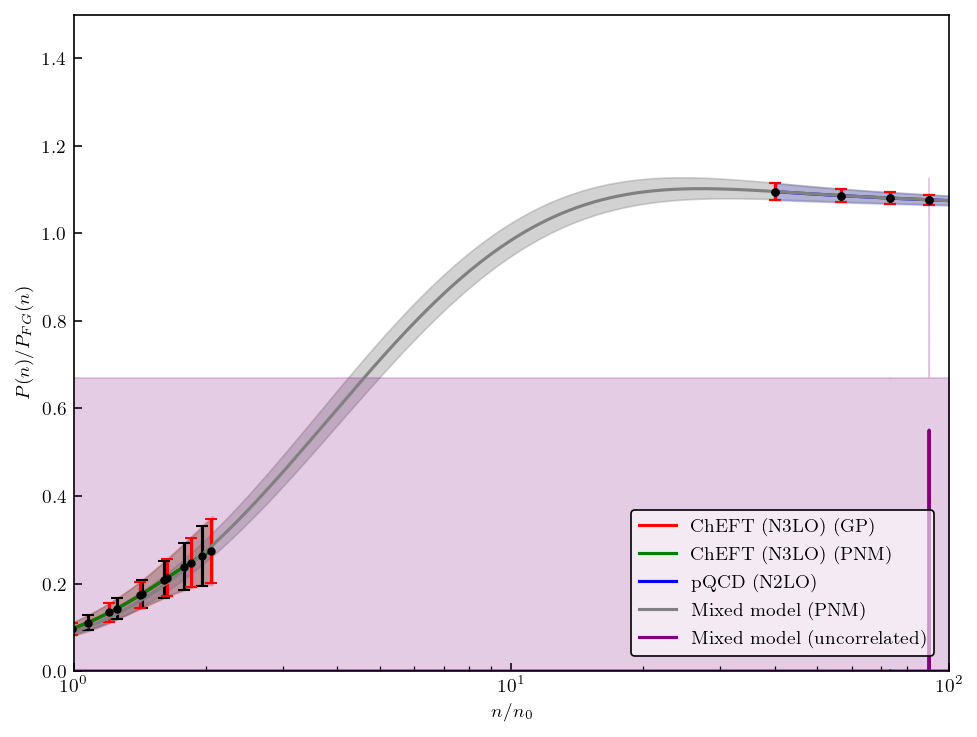

[1.32235633 1.33417882 1.33317146 1.33018909 1.32696295 1.32350856
 1.31987522 1.31613974 1.31237675 1.30864819 1.30500152 1.30147113
 1.29808059 1.29484509 1.29177338 1.28886942 1.2861337  1.28356415
 1.28115692 1.27890694 1.27680832 1.27485466 1.27303929 1.27135541
 1.26979627 1.2683552  1.26702571 1.26580148 1.26467649 1.26364491
 1.26270123 1.26184015 1.26105669 1.2603461  1.25970389 1.25912582
 1.25860788 1.25814629 1.2577375  1.25737814 1.25706505 1.25679527
 1.25656598 1.25637456 1.25621853 1.25609557 1.25600347 1.25594018
 1.25590377 1.25589242 1.25590441 1.25593815 1.25599211 1.2560649
 1.25615516 1.25626166 1.25638321 1.25651872 1.25666714 1.2568275
 1.25699889 1.25718044 1.25737137 1.2575709  1.25777834 1.257993
 1.25821428 1.25844159 1.25867438 1.25891213 1.25915436 1.25940063
 1.25965051 1.2599036  1.26015954 1.26041798 1.2606786  1.26094109
 1.26120518 1.2614706  1.2617371  1.26200447 1.26227248 1.26254094
 1.26280966 1.26307847 1.26334722 1.26361575 1.26388394 1.26415165

In [32]:
# now we try this without any off-diagonal, aka a purely uncorrelated result in chiral EFT
kernel_uncorr = C(constant_value=0.6) * RBF(length_scale=2.0)

# save the matrix
cov_uncorr = training_data_2['cov']  # test with this and with one np.diag

# train on uncorrelated data in chiral EFT
for i in range(4):
    for j in range(4):
        if i != j:
            cov_uncorr[i,j] = 0.0
            
#print(cov_uncorr)

# write the GP and train
gp_uncorr = GaussianProcessRegressor2dNoise(kernel=kernel_uncorr, 
                                            n_restarts_optimizer=10, 
                                            alpha=cov_uncorr)

gp_uncorr.fit(X_train_2, y_train_2)

print(gp_uncorr.kernel_)

# predict
y_pred_uncorr, y_stdv_uncorr = gp_uncorr.predict(X, return_std=True)

# plot result and compare to the original result here for PNM matrix
fig, ax = plt.subplots(dpi=150)
ax.set_xlim(1.0, 100.0)
ax.set_ylim(0, 1.5)
ax.set_xscale('log') # plot in log base 10
ax.set_xlabel(r'$n/n_{0}$')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$')

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft_1/n0, p_mean_xeft_1, color='red', label=r'ChEFT (N3LO) (GP)')
ax.fill_between(n_xeft_1/n0, p_mean_xeft_1-p_stdv_xeft_1, p_mean_xeft_1+p_stdv_xeft_1, alpha=0.2, \
                color=color_xeft_1)
ax.errorbar(x=training_data_1['dens']/n0, y=training_data_1['mean'], yerr=training_data_1['std'], \
            **errorbar_kwargs_1)

ax.plot(n_xeft_2/n0, p_mean_xeft_2, color='green', label=r'ChEFT (N3LO) (PNM)')
ax.fill_between(n_xeft_2/n0, p_mean_xeft_2-p_stdv_xeft_2, p_mean_xeft_2+p_stdv_xeft_2, alpha=0.2, \
                color=color_xeft_2)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)

ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)

# GP result and uncertainty band
ax.plot(density_test/n0, y_pred_2, c='grey', label=r'Mixed model (PNM)')
ax.fill_between(density_test/n0, y_pred_2-y_stdv_2, y_pred_2+y_stdv_2, color="grey", alpha=0.35)

ax.plot(density_test/n0, y_pred_uncorr, c='purple', label=r'Mixed model (uncorrelated)')
ax.fill_between(density_test/n0, y_pred_uncorr-y_stdv_uncorr, y_pred_uncorr+y_stdv_uncorr, \
                color="purple", alpha=0.2)

plt.legend(loc='lower right')
plt.show()

print(-(2.0*y_stdv_2) + (2.0*y_stdv_uncorr))

Below we print out some values of the pQCD and mixed model EOSs that we use in Table III of our paper (Sec. IV B).

In [59]:
# print out values for Table III
# print('GP values: P(n) and 1-sigma uncertainty:')
# seldens = 4
# from scipy.interpolate import interp1d
# gp_mean_interp = interp1d(density_test, y_pred, kind='cubic', fill_value='extrapolate')
# print(gp_mean_interp(seldens*0.164)*convert_interp(seldens*0.164))
# gp_std_interp = interp1d(density_test, y_stdv, kind='cubic', fill_value='extrapolate')
# print(gp_std_interp(seldens*0.164)*convert_interp(seldens*0.164))

# # print out pQCD values for Table III
# print('\npQCD values: P(n) and 1-sigma uncertainty:')
# pqcd_mean_interp = interp1d(data_pqcd['density'][19:], data_pqcd['mean'][19:,2], \
#                             kind='linear', fill_value='extrapolate')
# print(pqcd_mean_interp(seldens*0.164)*convert_interp(seldens*0.164))
# pqcd_std_interp = interp1d(data_pqcd['density'][19:], data_pqcd['std_dev'][19:,2], \
#                            kind='linear', fill_value='extrapolate')
# print(pqcd_std_interp(seldens*0.164)*convert_interp(seldens*0.164))

---

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="calc_cs2"></a>

We need to extract the speed of sound from the pressure equation. The most direct way to do this is to integrate the $P(n)$ curve to get the energy density, as we did as well in the pointwise mixing notebook. 

$$
P(n) = n^{2} \frac{\partial (\varepsilon/n)}{\partial n}
$$

$$
\varepsilon(n) = n \left[\int_{n}^{n_{i}} \frac{P(n)}{n^{2}} dn + \frac{\varepsilon(n_{i})}{n_{i}} \right],
$$

where $n_{i}$ is 16.4 fm$^{-3}$, as we will be integrating downwards from pQCD to $\chi$EFT in this approach.

After we achieve the energy density in this manner, we will then code the chemical potential as

$$
\mu(n) = \frac{P(n) + \varepsilon(n)}{n},
$$

and finally obtain the speed of sound, given as

$$
c_{s}^{2}(n) = \frac{\partial P}{\partial n } / \frac{\partial \varepsilon}{\partial n} = \frac{1}{\mu(n)} \frac{\partial P(n)}{\partial n}.
$$

We have a utility function that runs both the integration and the speed of sound calculation, so we will call that and implement the speed of sound. However, we first need to sample from the GP, since this is the way to best propagate the uncertainties from the pressure to the speed of sound without drastically overestimating them.

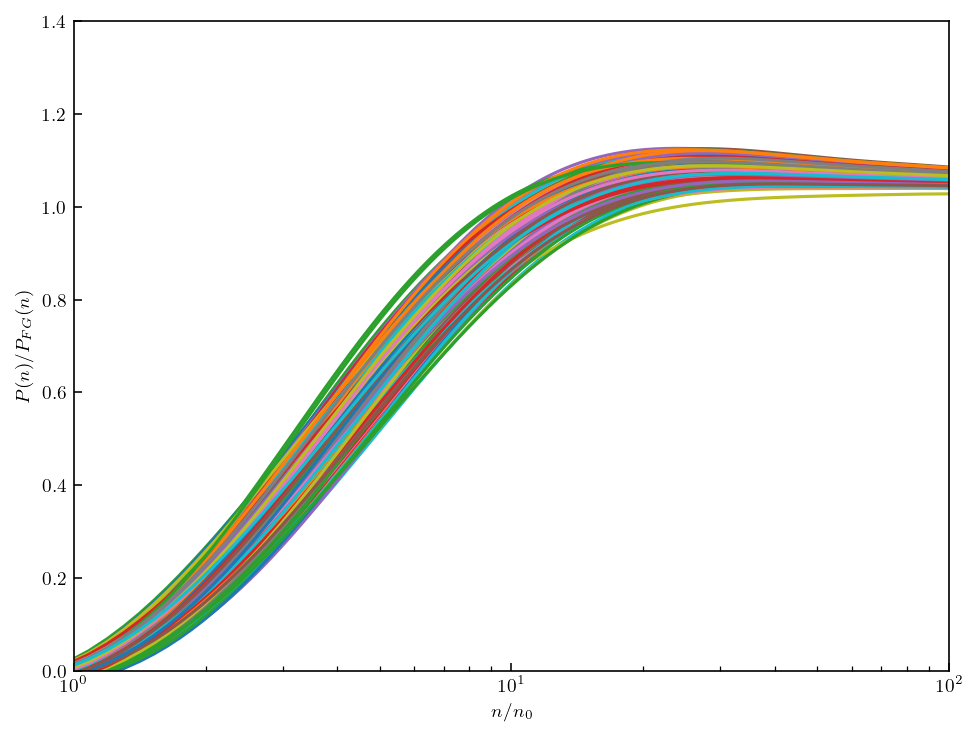

In [14]:
# sample from the pressure GP curve first
samples_data = gp.sample_y(X=np.log(density_test.reshape(-1,1)), n_samples=500)

# plot the samples to test the validity of the call
plt.plot(density_test/n0, samples_data)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.4)
plt.xscale('log')
plt.ylabel(r'$P(n)/P_{FG}(n)$')
plt.xlabel(r'$n/n_{0}$')
plt.show()

(893, 500)
(893, 500)


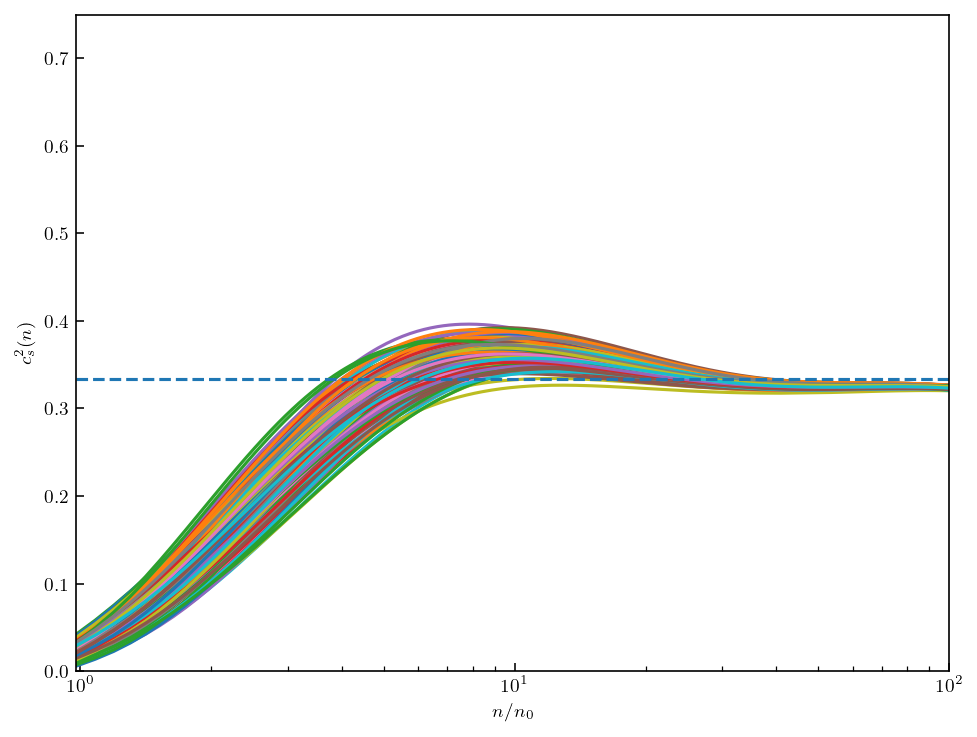

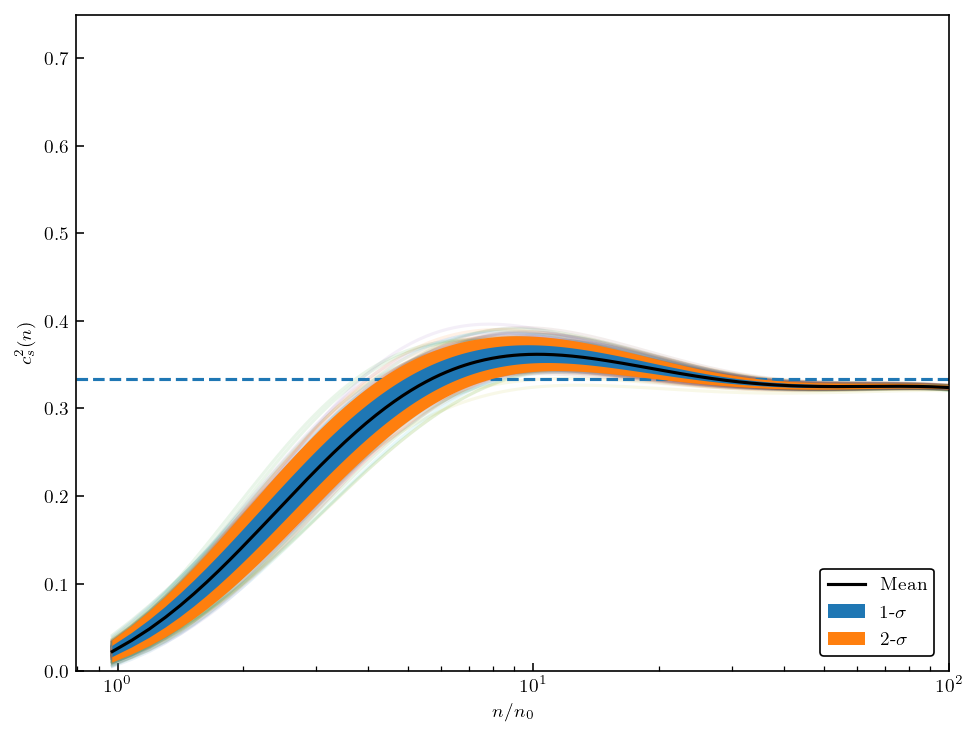

In [15]:
# integrate backward to anchor at pQCD and plot the speed of sound result
pres_samples = samples_data

# run interpolation for FG scaling (needed for determination 
# of P(n) from scaled result)
gp_cs2_convert_arr = convert_interp(density_test)

# unscale the samples from the FG scaling
pres_samples_unscaled = [pres_samples[:,i]*gp_cs2_convert_arr \
                         for i in range(len(np.asarray(pres_samples).T))]

# cut at saturation (or thereabouts; unstable matter under saturation for symmetric)
sat_cut = (np.where([i >= 0.164 for i in density_test])[0][0]) - 1

# pull dict values out and make arrays
gp_mean = y_pred
gp_std = y_stdv

# send to the speed of sound calculation (for interpolation)
pres_dict = {
    'mean': gp_mean[sat_cut:]*gp_cs2_convert_arr[sat_cut:],
    'std_dev': gp_std[sat_cut:]*gp_cs2_convert_arr[sat_cut:],
    'samples': np.asarray(pres_samples_unscaled)[:, sat_cut:].T
}

# integrating downwards from pQCD
# (results here from pQCD notebook boundary_conditions function)
en_0 = 49210.54331120984       # BC at 100*n0
en_0_lower = 49079.01210179091 
en_0_upper = 49342.07447863117

# make dict of values to send to speed of sound code
edens_dict = {
    'mean': en_0, 
    'lower': en_0_lower,
    'upper': en_0_upper
}

# call speed of sound function (sampled = True automatically runs the integration downwards)
cs2_sampled, edens_full = speed_of_sound(density_test[sat_cut:], pres_dict, \
                                         edens_dict, sat=False, sampled=True)

# save for plotting later (uncomment to save)
# np.savez('../data/eos_data/cs2_gp_40.npz', dens=density_test[sat_cut:], mean=cs2_log['mean'],\
#          std=cs2_log['std'], samples=cs2_log['samples'])

# dict entries 
cs2_sampled_mean = cs2_sampled['mean']
cs2_sampled_std = cs2_sampled['std']
cs2_sampled_samples = cs2_sampled['samples']

# samples plot
[plt.plot(density_test[sat_cut:]/n0, cs2_sampled_samples[i]) for i in range(len(edens_full))]
plt.axhline(y=1.0/3.0, linestyle='dashed')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$c_{s}^{2}(n)$')
plt.xlim(0.16/n0, 16.4/n0)
plt.xscale('log')
plt.ylim(0.0, 0.75)
plt.show()

# mean and std dev band plot
[plt.plot(density_test[sat_cut:]/n0, cs2_sampled_samples[i], alpha=0.1) for i in range(len(edens_full))]
plt.plot(density_test[sat_cut:]/n0, cs2_sampled_mean, 'k', zorder=20, label=r'Mean')
plt.fill_between(density_test[sat_cut:]/n0, \
                 cs2_sampled_mean-cs2_sampled_std, cs2_sampled_mean+cs2_sampled_std, zorder=12, \
                 label=r'1-$\sigma$')
plt.fill_between(density_test[sat_cut:]/n0, \
                 cs2_sampled_mean-1.96*cs2_sampled_std, cs2_sampled_mean+1.96*cs2_sampled_std, \
                 label=r'2-$\sigma$', zorder=10)
plt.axhline(y=1.0/3.0, linestyle='dashed')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$c_{s}^{2}(n)$')
plt.xlim(0.13/n0, 16.4/n0)
plt.xscale('log')
plt.ylim(0.0, 0.75)
plt.legend(loc='lower right')
plt.show()

Excellent! Now we have our samples, so we can plot the results for $P(n)$ and $c_{s}^{2}(n)$ side-by-side like in Sec. IV of our paper. First we will import the speed of sound data from the $\chi$EFT and pQCD results.

In [16]:
# import the speed of sound data from ChEFT and pQCD
cs2_chiral = np.load('../data/eos_data/speedofsoundchiral.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_11.2.npz')

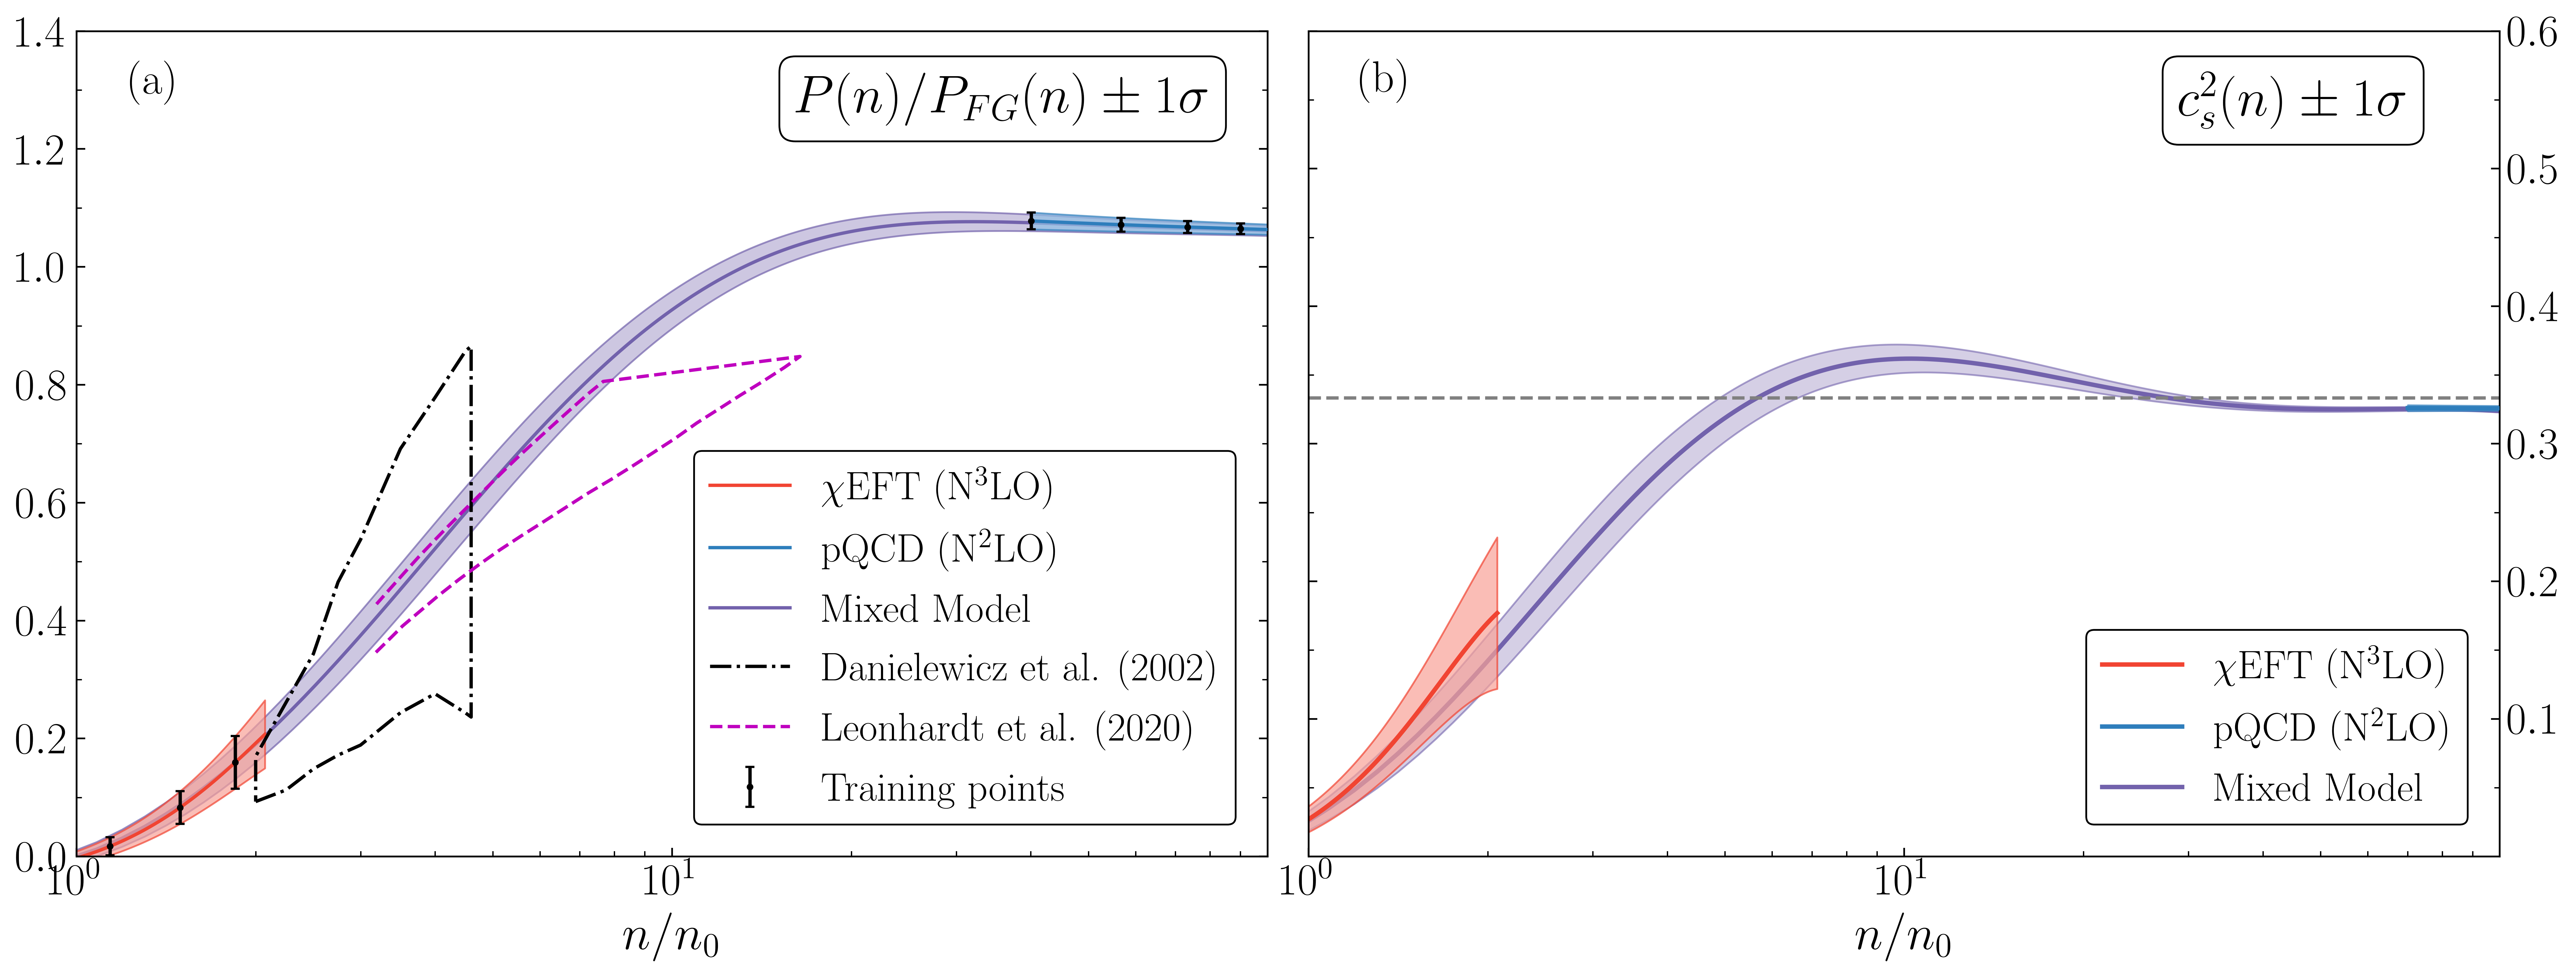

In [18]:
# set up the plot requirements
fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=600, sharex='col')
#fig.patch.set_alpha(0.0)
ax[0].set_xlim(1.00, max(density_test/n0))
ax[0].set_ylim(0.0,1.4)
ax[0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0].xaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0].text(1.5, 1.35, r'(a)', ha='right', va='top', fontsize=20)
ax[0].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[0].set_xscale('log')

ax[1].set_xlim(1., max(density_test/n0))
ax[1].set_ylim(1e-6,0.6)
ax[1].xaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1].text(1.5, 0.58, r'(b)', ha='right', va='top', fontsize=20)
ax[1].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1].set_xscale('log')

orders = [0,1,2]

# plotting assistance
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# assign means and std devs for easier use
mean_chiral = data_xeft['mean'][:,3]
mean_pqcd = data_pqcd['mean'][:,2]
std_dev_chiral = data_xeft['std_dev'][:,3]
std_dev_pqcd = data_pqcd['std_dev'][:,2]

# pressure data

# model means and uncertainties
ax[0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax[0].fill_between(data_pqcd['density'][ind_cut:]/n0, mean_pqcd[ind_cut:] - \
                   1.0*std_dev_pqcd[ind_cut:], mean_pqcd[ind_cut:] + 1.0*std_dev_pqcd[ind_cut:], \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0].plot(data_pqcd['density'][ind_cut:]/n0, mean_pqcd[ind_cut:], zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax[0].fill_between(density_test/n0, gp_mean-1.0*gp_std, gp_mean+ \
                   1.0*gp_std,
                       zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0].plot(density_test/n0, gp_mean, color=colors[2], zorder=-1, label='Mixed Model')
  
# plot FRG and HIC contours
ax[0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', \
           zorder=10, label='Danielewicz et al. (2002)')
ax[0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', \
           zorder=10, label='Leonhardt et al. (2020)')

# plot the training points
ax[0].errorbar(training_data["dens"]/n0, training_data["mean"], yerr=training_data["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[0].legend(loc='lower right', facecolor='w', fontsize=18)

# speed of sound data 
ax[1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3]+cs2_chiral['std'][:,3], \
                 cs2_chiral['mean'][:,3]-cs2_chiral['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
plt.plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
plt.fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[1].fill_between(density_test[sat_cut:]/n0, cs2_sampled['mean']-cs2_sampled['std'], \
                   cs2_sampled['mean']+cs2_sampled['std'],\
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[1].plot(density_test[sat_cut:]/n0, cs2_sampled['mean'], color=colors[2], linewidth=2, zorder=-1, \
           label=r'Mixed Model')

ax[1].legend(loc='lower right', facecolor='w', fontsize=18)
plt.show()
#fig.savefig('subplot_curvewise_model_40n0.PNG', bbox_inches='tight')

## Creating the multi-plot figure in the paper

Below is the code we used to generate the 4 panel figure in our paper. 

In [19]:
# Fig. 8 in our paper

# load in each file of results needed for P(n)
data_xeft = np.load('../data/eos_data/pressure_chiral_data_scaled_2n0.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_cut_20.npz')
data_pqcd_40 = np.load('../data/eos_data/pressure_pqcd_cut_40.npz')
df = pd.read_csv('../data/contour_scaled.csv')
df_frg = pd.read_csv('../data/frg_data_pressure.csv')
training_data_20 = np.load('../data/eos_data/correlated_training_data_20n0.npz')
training_data_40 = np.load('../data/eos_data/correlated_training_data_40n0.npz')
pressure_gp_20 = np.load('../data/eos_data/gp_pressure_20.npz')
pressure_gp_40 = np.load('../data/eos_data/gp_pressure_40.npz')

# load in each file of results need for cs2(n)
cs2_chiral = np.load('../data/eos_data/speedofsoundchiral.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_11.2.npz')
cs2_GP_20 = np.load('../data/eos_data/cs2_gp_20.npz')
cs2_GP_40 = np.load('../data/eos_data/cs2_gp_40.npz')

# set up the orders and labels
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# assign means and std devs for easier use for chiral, pqcd data
dens_pqcd = data_pqcd['dens']
dens_pqcd_40 = data_pqcd_40['dens']
mean_chiral = data_xeft['mean'][:,3]
mean_pqcd = data_pqcd['mean']
mean_pqcd_40 = data_pqcd_40['mean']
std_dev_chiral = data_xeft['std_dev'][:,3]
std_dev_pqcd = data_pqcd['std']
std_dev_pqcd_40 = data_pqcd_40['std']

In [22]:
# now we need to create the skeleton of the figure
fig, ax = plt.subplots(2, 2, figsize=(16,12), dpi=600, sharex='col')

# first row
ax[0,0].set_xlim(1.00, 100.)
ax[0,0].set_ylim(0.0,1.4)
ax[0,0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0,0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0,0].xaxis.set_major_locator(MultipleLocator(10))
ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0,0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0,0].text(2.0, 1.35, r'(a) 20$n_{0}$', ha='right', va='top', fontsize=20)
ax[0,0].set_xscale('log')

### pressure for panel (a) ###

# model means and uncertainties
ax[0,0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[0,0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax[0,0].fill_between(dens_pqcd/n0, mean_pqcd - \
                   1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0,0].plot(dens_pqcd/n0, mean_pqcd, zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax[0,0].fill_between(pressure_gp_20['dens']/n0, pressure_gp_20['mean']-1.0*pressure_gp_20['std'],\
                   pressure_gp_20['mean']+ 1.0*pressure_gp_20['std'], \
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0,0].plot(pressure_gp_20['dens']/n0, pressure_gp_20['mean'], color=colors[2], zorder=-1,\
             label='Mixed Model')
  
# plot FRG and HIC contours
ax[0,0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', \
           zorder=10, label='Danielewicz et al. (2002)')
ax[0,0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', \
           zorder=10, label='Leonhardt et al. (2020)')

# plot the training points
ax[0,0].errorbar(training_data_20["density"]/n0, training_data_20["mean"], yerr=training_data_20["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[0,0].legend(loc='lower right', facecolor='w', fontsize=18)

ax[0,1].set_xlim(1., 100.)
ax[0,1].set_ylim(0.0,0.6)
ax[0,1].xaxis.set_major_locator(MultipleLocator(10))
ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0,1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[0,1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[0,1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0,1].text(2.0, 0.58, r'(b) 20$n_{0}$', ha='right', va='top', fontsize=20)
ax[0,1].set_xscale('log')

### speed of sound for panel (b) ###

ax[0,1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[0,1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3]+cs2_chiral['std'][:,3], \
                 cs2_chiral['mean'][:,3]-cs2_chiral['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[0,1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
ax[0,1].plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
ax[0,1].fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[0,1].fill_between(cs2_GP_20['dens']/n0, cs2_GP_20['mean']-cs2_GP_20['std'], \
                     cs2_GP_20['mean']+cs2_GP_20['std'],\
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[0,1].plot(cs2_GP_20['dens']/n0, cs2_GP_20['mean'], color=colors[2], linewidth=2, zorder=-1, \
           label=r'Mixed Model')

ax[0,1].legend(loc='lower right', facecolor='w', fontsize=18)

# next row
ax[1,0].set_xlim(1.00, 100.)
ax[1,0].set_ylim(0.0,1.4)
ax[1,0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[1,0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[1,0].xaxis.set_major_locator(MultipleLocator(10))
ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[1,0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1,0].text(2.0, 1.35, r'(c) 40$n_{0}$', ha='right', va='top', fontsize=20)
ax[1,0].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1,0].set_xscale('log')

### pressure for panel (c)

# model means and uncertainties
ax[1,0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[1,0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax[1,0].fill_between(dens_pqcd_40/n0, mean_pqcd_40 - \
                   1.0*std_dev_pqcd_40, mean_pqcd_40 + 1.0*std_dev_pqcd_40, \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[1,0].plot(dens_pqcd_40/n0, mean_pqcd_40, zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax[1,0].fill_between(pressure_gp_40['dens']/n0, pressure_gp_40['mean']-1.0*pressure_gp_40['std'],\
                   pressure_gp_40['mean']+ 1.0*pressure_gp_40['std'], \
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[1,0].plot(pressure_gp_40['dens']/n0, pressure_gp_40['mean'], color=colors[2], zorder=-1, \
             label='Mixed Model')
  
# plot FRG and HIC contours
ax[1,0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', \
           zorder=10, label='Danielewicz et al. (2002)')
ax[1,0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', \
           zorder=10, label='Leonhardt et al. (2020)')

# plot the training points
ax[1,0].errorbar(training_data_40["density"]/n0, training_data_40["mean"], yerr=training_data_40["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[1,0].legend(loc='lower right', facecolor='w', fontsize=18)

ax[1,1].set_xlim(1., 100.)
ax[1,1].set_ylim(1e-6,0.6)
ax[1,1].xaxis.set_major_locator(MultipleLocator(10))
ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1,1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1,1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1,1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1,1].text(2.0, 0.58, r'(d) 40$n_{0}$', ha='right', va='top', fontsize=20)
ax[1,1].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1,1].set_xscale('log')

### speed of sound for panel (d) ###

ax[1,1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[1,1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3]+cs2_chiral['std'][:,3], \
                 cs2_chiral['mean'][:,3]-cs2_chiral['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1,1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
ax[1,1].plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
ax[1,1].fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[1,1].fill_between(cs2_GP_40['dens']/n0, cs2_GP_40['mean']-cs2_GP_40['std'], \
                     cs2_GP_40['mean']+cs2_GP_40['std'],\
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[1,1].plot(cs2_GP_40['dens']/n0, cs2_GP_40['mean'], color=colors[2], linewidth=2, zorder=-1, \
           label=r'Mixed Model')

ax[1,1].legend(loc='lower right', facecolor='w', fontsize=18)

#fig.savefig('joint_subplot_curvewise.PNG')
plt.show()

Alexandra Semposki, 01 April 2024.